In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

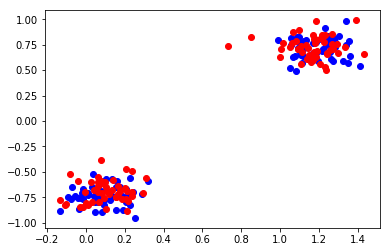

In [2]:
num_dims  =  2
num_centroids = 2
num_samples = 100
num_batch = 32

assert num_samples % num_centroids == 0

data_points = []
test_points = []

for i in range(num_dims):
    centroids = np.random.normal(0, 1, [num_centroids, 1])
    
    samples = centroids + np.random.normal(
        0, 0.1, [num_centroids, num_samples // num_centroids])
    tests = centroids + np.random.normal(
        0, 0.1, [num_centroids, num_samples // num_centroids])
    
    data_points.append(samples.flatten())
    test_points.append(tests.flatten())
    
data_points = np.stack(data_points).T
test_points = np.stack(test_points).T

data_labels = np.reshape(
    np.tile(
        np.eye(num_centroids)[:, np.newaxis, :], 
        [1, num_samples // num_centroids, 1]), 
    [num_samples, num_centroids])
test_labels = data_labels

plt.plot(data_points[:, 0], data_points[:, 1], "bo")
plt.plot(test_points[:, 0], test_points[:, 1], "ro")

In [3]:
g = tf.Graph()
s = tf.Session(graph=g)

with g.as_default():
    
    data_in = tf.placeholder(
        tf.float32, shape=[num_samples, num_dims], name="data_in")
    labels_in = tf.placeholder(
        tf.float32, shape=[num_samples, num_centroids], name="labels_in")
    
    weights = tf.get_variable(
        name="weights",
        shape=[num_dims, num_centroids],
        initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(
        name="biases",
        shape=[num_centroids],
        initializer=tf.zeros_initializer())
    
    logits = tf.nn.xw_plus_b(data_in, weights, biases)
    probs = tf.nn.softmax(logits)
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits,
            labels=labels_in))
    _, accuracy = tf.metrics.accuracy(
        tf.argmax(labels_in, axis=1),
        tf.argmax(probs, axis=1))
    
    global_step = tf.Variable(
        0, name="global_step", trainable=False)
    learning_rate = tf.train.exponential_decay(
        0.01,
        global_step,
        1000,
        0.5)
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate)
    
    gradients = optimizer.compute_gradients(
        cross_entropy,
        var_list=[weights, biases])
    updates = optimizer.apply_gradients(
        gradients, 
        global_step=global_step)
    
    global_op = tf.global_variables_initializer()
    local_op = tf.local_variables_initializer()
    
g.finalize()

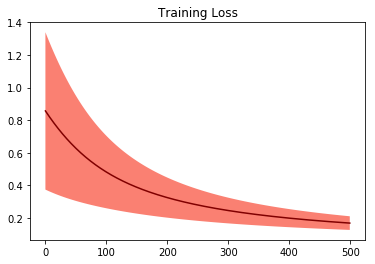

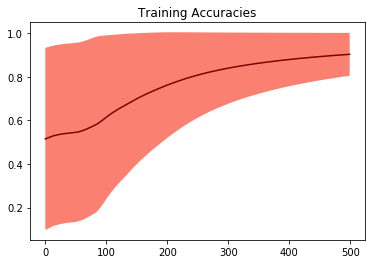

In [4]:
num_iterations = 500
num_logs = 1
num_repeats = 10
debug = False

losses = []
accuracies = []

for r in range(num_repeats):
    current_loss = []
    current_accuracy = []
    s.run([global_op, local_op])

    for i in range(num_iterations):

        results = s.run(
            [cross_entropy, accuracy, updates],
            feed_dict={
                "data_in:0": data_points,
                "labels_in:0": data_labels})
        
        current_loss.append([results[0], i])
        current_accuracy.append([results[1], i])

        if i % (num_iterations // num_logs) == 0 and debug:
            print(
                "iteration: %d" % i,
                "loss: %.2f" % results[0],
                "accuracy: %.2f" % (100.0 * results[1]))
            
    losses.append(current_loss)
    accuracies.append(current_accuracy)
    
losses = np.array(losses)
accuracies = np.array(accuracies)

mean_losses = np.mean(losses[:, :, 0], axis=0)
std_losses = np.std(losses[:, :, 0], axis=0)
ind_losses = losses[0, :, 1]

mean_accuracies = np.mean(accuracies[:, :, 0], axis=0)
std_accuracies = np.std(accuracies[:, :, 0], axis=0)
ind_accuracies = accuracies[0, :, 1]

plt.fill_between(
    ind_losses, 
    mean_losses + std_losses,
    mean_losses - std_losses, 
    facecolor='salmon', 
    interpolate=True)
plt.plot(ind_losses, mean_losses, color="maroon")
plt.title("Training Loss")
plt.show()

plt.close()

plt.fill_between(
    ind_accuracies, 
    mean_accuracies + std_accuracies,
    mean_accuracies - std_accuracies, 
    facecolor='salmon', 
    interpolate=True)
plt.plot(ind_accuracies, mean_accuracies, color="maroon")
plt.title("Training Accuracies")
plt.show()

In [5]:
g_attend = tf.Graph()
s_attend = tf.Session(graph=g_attend)

with g_attend.as_default():
    
    data_in = tf.placeholder(
        tf.float32, shape=[num_samples, num_dims], name="data_in")
    labels_in = tf.placeholder(
        tf.float32, shape=[num_samples, num_centroids], name="labels_in")
    
    weights = tf.get_variable(
        name="weights",
        shape=[num_dims, num_centroids],
        initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(
        name="biases",
        shape=[num_centroids],
        initializer=tf.zeros_initializer())
    
    weights_adv = tf.get_variable(
        name="weights_adv",
        shape=[num_dims + num_centroids, 1],
        initializer=tf.contrib.layers.xavier_initializer())
    biases_adv = tf.get_variable(
        name="biases_adv",
        shape=[1],
        initializer=tf.zeros_initializer())
    
    logits = tf.nn.xw_plus_b(data_in, weights, biases)
    probs = tf.nn.softmax(logits)
    indices = tf.argmax(probs, axis=1)
    one_hot = tf.one_hot(indices, num_centroids)
    
    match_in = tf.concat([data_in, one_hot], axis=1)
    logits_adv = tf.nn.xw_plus_b(match_in, weights_adv, biases_adv)
    attention = tf.transpose(tf.nn.softmax(tf.transpose(logits_adv)))
    
    cross_entropy = tf.reduce_sum(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits,
            labels=labels_in) * attention)
    _, accuracy = tf.metrics.accuracy(
        tf.argmax(labels_in, axis=1),
        tf.argmax(probs, axis=1))
    
    global_step = tf.Variable(
        0, name="global_step", trainable=False)
    learning_rate = tf.train.exponential_decay(
        0.01,
        global_step,
        1000,
        0.5)
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate)
    
    gradients = optimizer.compute_gradients(
        cross_entropy,
        var_list=[weights, biases])
    gradients_adv = optimizer.compute_gradients(
        -cross_entropy,
        var_list=[weights_adv, biases_adv])
    updates = optimizer.apply_gradients(
        gradients + gradients_adv, 
        global_step=global_step)
    
    global_op = tf.global_variables_initializer()
    local_op = tf.local_variables_initializer()
    
g_attend.finalize()

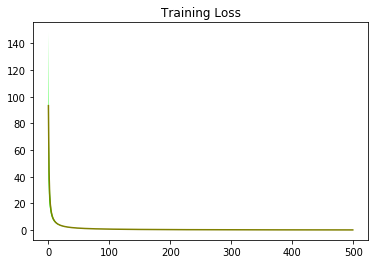

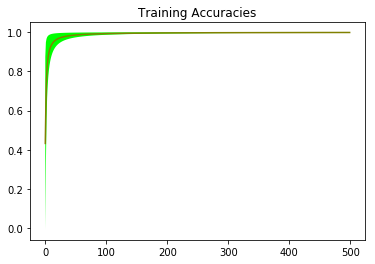

In [6]:
num_iterations = 500
num_logs = 1
num_repeats = 10
debug = False

losses = []
accuracies = []

for r in range(num_repeats):
    current_loss = []
    current_accuracy = []
    s_attend.run([global_op, local_op])

    for i in range(num_iterations):

        results = s_attend.run(
            [cross_entropy, accuracy, updates],
            feed_dict={
                "data_in:0": data_points,
                "labels_in:0": data_labels})
        
        current_loss.append([results[0], i])
        current_accuracy.append([results[1], i])

        if i % (num_iterations // num_logs) == 0 and debug:
            print(
                "iteration: %d" % i,
                "loss: %.2f" % results[0],
                "accuracy: %.2f" % (100.0 * results[1]))
            
    losses.append(current_loss)
    accuracies.append(current_accuracy)
    
losses = np.array(losses)
accuracies = np.array(accuracies)

mean_losses = np.mean(losses[:, :, 0], axis=0)
std_losses = np.std(losses[:, :, 0], axis=0)
ind_losses = losses[0, :, 1]

mean_accuracies = np.mean(accuracies[:, :, 0], axis=0)
std_accuracies = np.std(accuracies[:, :, 0], axis=0)
ind_accuracies = accuracies[0, :, 1]

plt.fill_between(
    ind_losses, 
    mean_losses + std_losses,
    mean_losses - std_losses, 
    facecolor='lime', 
    interpolate=True)
plt.plot(ind_losses, mean_losses, color="olive")
plt.title("Training Loss")
plt.show()

plt.close()

plt.fill_between(
    ind_accuracies, 
    mean_accuracies + std_accuracies,
    mean_accuracies - std_accuracies, 
    facecolor='lime', 
    interpolate=True)
plt.plot(ind_accuracies, mean_accuracies, color="olive")
plt.title("Training Accuracies")
plt.show()